/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimal Threshold: 0.5940
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1060
           1       0.57      0.52      0.54        31

    accuracy                           0.98      1091
   macro avg       0.78      0.75      0.76      1091
weighted avg       0.97      0.98      0.97      1091

Precision-Recall AUC: 0.4388


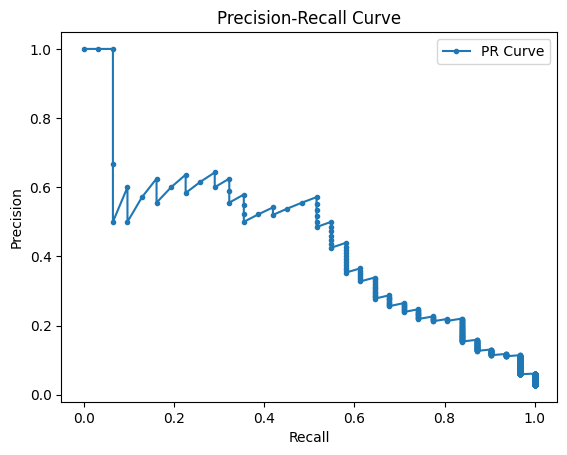

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("Train.csv")  # Replace with your actual dataset

# Split target and features
y = df.iloc[:, 0]   # First column is the target variable
X = df.iloc[:, 1:]  # Remaining columns are features

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize data for better Autoencoder performance
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Autoencoder on Non-Bankrupt Companies (Majority Class)
X_train_normal = X_train_scaled[y_train == 0]  # Train on normal (non-bankrupt) data only

# Define Autoencoder Model
input_dim = X_train_normal.shape[1]
autoencoder = keras.Sequential([
    keras.layers.InputLayer(input_shape=(input_dim,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),  # Bottleneck (compressed representation)
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')  # Output layer (reconstruction)
])

# Compile and Train Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# Compute Reconstruction Error as Anomaly Score
X_train_reconstructed = autoencoder.predict(X_train_scaled)
X_test_reconstructed = autoencoder.predict(X_test_scaled)

train_errors = np.mean(np.abs(X_train_scaled - X_train_reconstructed), axis=1)
test_errors = np.mean(np.abs(X_test_scaled - X_test_reconstructed), axis=1)

# Add Anomaly Score as Feature
X_train["autoencoder_score"] = train_errors
X_test["autoencoder_score"] = test_errors

# Apply SMOTE-Tomek for Balancing
smote_tomek = SMOTETomek(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote_tomek.fit_resample(X_train, y_train)

# Train XGBoost Classifier
xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False,
                    scale_pos_weight=2, learning_rate=0.05, max_depth=5, n_estimators=200)
xgb.fit(X_train_smote, y_train_smote)

# Predict Probabilities
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

# Find Best Threshold Using Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# Make Predictions Using Best Threshold
y_pred = (y_pred_prob >= best_threshold).astype(int)

# Evaluation
print(f"Optimal Threshold: {best_threshold:.4f}")
print(classification_report(y_test, y_pred))

# Precision-Recall AUC
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot Precision-Recall Curve
plt.plot(recall, precision, marker='.', label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()